In [1]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Conv2DTranspose, Flatten, Dropout, ReLU, Input, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, Model

import numpy as np

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

LOAD DATABASES, CONCATENATE AND MIX THEM

In [2]:
rv = [54.]
nr = len(rv)



def load_and_shuffle_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    
    n_traj = 50000
    db = np.ndarray(shape=(nr*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(nr)):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)
    
    labels = np.array(labels)
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    db, labels = unison_shuffled_copies(db, labels)
    return db, labels




db, labels = load_and_shuffle_dbs(rv)

PREPROCESSING

In [3]:
validation_split = 0.0

sig_len = len(db[0,:,0])
print(f"siglen: {sig_len}")
channels = 1 #len(db[0,0,:])
print(f"channels: {channels}")
n_traj = len(db[:,0,0])
print((f"n_traj: {n_traj}"))
# numero della prima traiettoria usata come validation
first_validation = n_traj #   round((1. - validation_split)*n_traj)
#  print(f"first_validation: {first_validation}")
db_train = np.ndarray(shape=(first_validation,sig_len,channels))
#db_test = np.ndarray(shape=(n_traj-first_validation,sig_len,channels))
db_train = db[:first_validation,:,0:channels]
#db_test = db[first_validation:,:,0:channels]
del db

print(db_train.shape)
#M = np.max(np.append(db_train, db_test))
#m = np.min(np.append(db_train, db_test))
M = np.max(db_train)
m = np.min(db_train)
print(M,m)
db_train = (db_train - m)/(M - m)
#db_test = (db_test - m)/(M - m)
M = np.max(db_train)
m = np.min(db_train)
print(M,m)

siglen: 2000
channels: 1
n_traj: 50000
(50000, 2000, 1)
31.27666666957781 -31.28223237314301
1.0 0.0


VISUALIZE DATA

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

def plot_trajs(noise, real_trajs=None, epoch=None):
    import matplotlib.pyplot as plt
    gen_trajs = gen.predict(noise)
    
    try:
        if real_trajs==None:
            plt.figure(figsize=(18, 2))
            for i, traj in enumerate(gen_trajs):
                plt.subplot(1, 1, i+1)
                plt.plot(traj)
                #plt.axis('off')
    except:
        plt.figure(figsize=(18, 4))
        for i, traj in enumerate(gen_trajs):
            plt.subplot(2, 1, i+1)
            plt.plot(traj)
            #plt.axis('off')
        for i in range(len(gen_trajs)):
            plt.subplot(2, 1, len(gen_trajs)+i+1)
            n = round(np.random.uniform(0,len(real_trajs[:,0,0])))
            plt.plot(real_trajs[n,:,:])
            #plt.axis('off')
    plt.tight_layout()
    plt.show()

ARCHITETTURA RETE NEURALE

# Generatore

In [10]:
class Conv1DTranspose(tensorflow.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid', kernel_initializer=RandomNormal(0, 0.02)):
        super().__init__()
        self.conv2dtranspose = tensorflow.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, kernel_initializer=RandomNormal(0, 0.02)
        )

    def call(self, x):
        x = tensorflow.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tensorflow.squeeze(x, axis=2)
        return x

noise_dim = 100
optimizer = Adam(0.0008)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = (20,1) # dimensione filtro
fm = 4 # numero filtri
init_sigma = 0.2 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.1

def create_gen():
    generator = Sequential()
    # Starting size
    d = 5
    #4x1
    generator.add(Dense(d*fm, activation='relu', kernel_initializer=RandomNormal(mean_init, init_sigma), input_dim=noise_dim))
    #20x1
    generator.add(Reshape((d, 1, fm)))
    #5x4
    generator.add(Conv2DTranspose(fm, fs, strides=(5,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU())
    #50x4
    generator.add(Conv2DTranspose(fm, fs, strides=(5,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU())
    #250x4
    generator.add(Conv2DTranspose(1, fs, strides=(4,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU())
    #2000x1
    generator.add(Conv2DTranspose(1, fs, strides=(4,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(Reshape((2000, 1)))
    return generator

gen = create_gen()
gen.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 1, 4)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 25, 1, 4)          324       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 25, 1, 4)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 125, 1, 4)         324       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 125, 1, 4)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 500, 1, 1)        

# Discriminatore

In [11]:
opt = Adam(0.00008)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 4 # numero filtri
sigma_init = 0.1 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.0
def create_disc():
    discriminator = Sequential()
    #2000x1
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #250x4
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #50x4
    discriminator.add(Conv1D(fm, fs, strides=5, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    
    discriminator.add(Conv1D(fm, fs, strides=5, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    #5x4
    discriminator.add(Flatten())
    #20x1
    #discriminator.add(Dense(4*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(1, activation='sigmoid'))
    #1x1
    opt = RMSprop()
    discriminator.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=opt)
    return discriminator

disc = create_disc()

disc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 500, 4)            84        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 125, 4)            324       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 25, 4)             324       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 4)              324       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,077
Trainable params: 1,077
Non-trainable params: 0
____________________________________________________

# Gan

In [12]:
# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
disc.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_traj = gen(gan_input)

gan_output = disc(fake_traj)

gan = Model(gan_input, gan_output)
#optimizer = Adam(0.0008)
optimizer = RMSprop()
gan.compile(loss='binary_crossentropy', optimizer=opt)

# Training

W0428 14:12:02.539209 46994924871168 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch: 0 	 Discriminator Loss: [2.4183884e-05, 1.0] 		 Generator Loss: 12.648844718933105


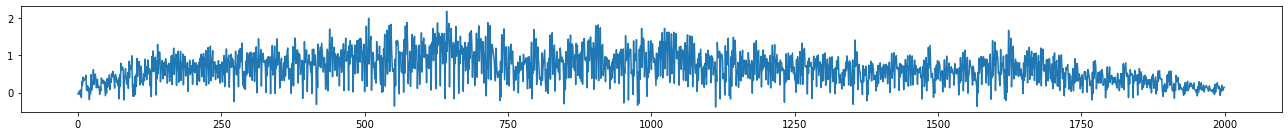

Epoch: 1 	 Discriminator Loss: [0.1382295, 1.0] 		 Generator Loss: 3.6208016872406006
Epoch: 2 	 Discriminator Loss: [0.04598301, 1.0] 		 Generator Loss: 5.909826755523682
Epoch: 3 	 Discriminator Loss: [0.07825124, 0.986] 		 Generator Loss: 5.252687454223633
Epoch: 4 	 Discriminator Loss: [0.071225345, 0.982] 		 Generator Loss: 7.639209747314453
Epoch: 5 	 Discriminator Loss: [0.029050482, 0.996] 		 Generator Loss: 7.3479413986206055


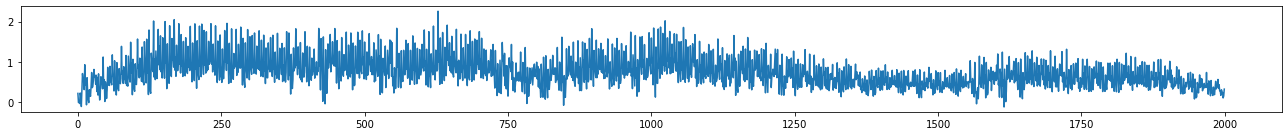

Epoch: 6 	 Discriminator Loss: [0.002801272, 1.0] 		 Generator Loss: 9.162997245788574
Epoch: 7 	 Discriminator Loss: [0.06612657, 0.996] 		 Generator Loss: 5.6135663986206055
Epoch: 8 	 Discriminator Loss: [0.0004842373, 1.0] 		 Generator Loss: 9.51249885559082
Epoch: 9 	 Discriminator Loss: [6.028285e-09, 1.0] 		 Generator Loss: 21.35219383239746
Epoch: 10 	 Discriminator Loss: [0.00016047733, 1.0] 		 Generator Loss: 10.548417091369629


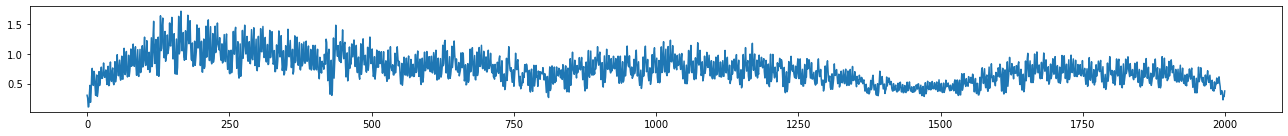

Epoch: 11 	 Discriminator Loss: [0.0020722982, 1.0] 		 Generator Loss: 7.429040431976318
Epoch: 12 	 Discriminator Loss: [0.0008014905, 1.0] 		 Generator Loss: 7.835514068603516
Epoch: 13 	 Discriminator Loss: [7.5793246e-06, 1.0] 		 Generator Loss: 12.009148597717285
Epoch: 14 	 Discriminator Loss: [1.616877e-06, 1.0] 		 Generator Loss: 16.518552780151367
Epoch: 15 	 Discriminator Loss: [4.205592e-06, 1.0] 		 Generator Loss: 14.466636657714844


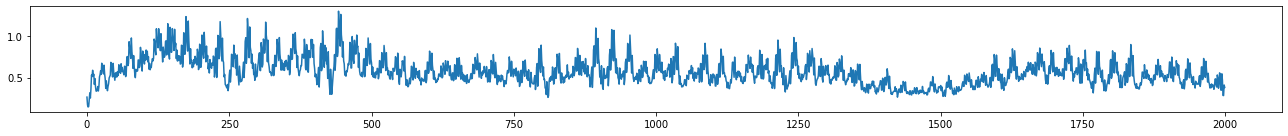

Epoch: 16 	 Discriminator Loss: [0.37276998, 0.796] 		 Generator Loss: 2.3931097984313965
Epoch: 17 	 Discriminator Loss: [0.014354927, 1.0] 		 Generator Loss: 5.268404960632324
Epoch: 18 	 Discriminator Loss: [3.0501844e-05, 1.0] 		 Generator Loss: 11.738513946533203
Epoch: 19 	 Discriminator Loss: [6.076397e-07, 1.0] 		 Generator Loss: 15.201423645019531
Epoch: 20 	 Discriminator Loss: [4.1989273e-07, 1.0] 		 Generator Loss: 15.323667526245117


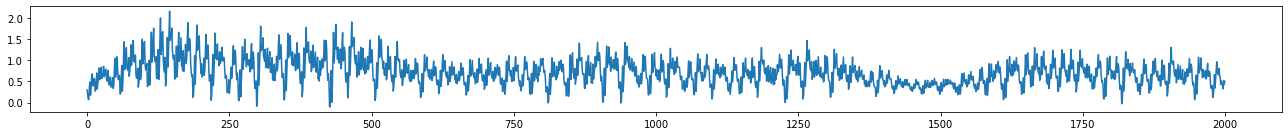

Epoch: 21 	 Discriminator Loss: [0.00014549412, 1.0] 		 Generator Loss: 10.00670051574707
Epoch: 22 	 Discriminator Loss: [0.25104135, 0.884] 		 Generator Loss: 0.7528815269470215
Epoch: 23 	 Discriminator Loss: [0.0016591179, 1.0] 		 Generator Loss: 7.446522235870361
Epoch: 24 	 Discriminator Loss: [0.00145855, 1.0] 		 Generator Loss: 8.52324390411377
Epoch: 25 	 Discriminator Loss: [3.8540642e-05, 1.0] 		 Generator Loss: 10.77465534210205


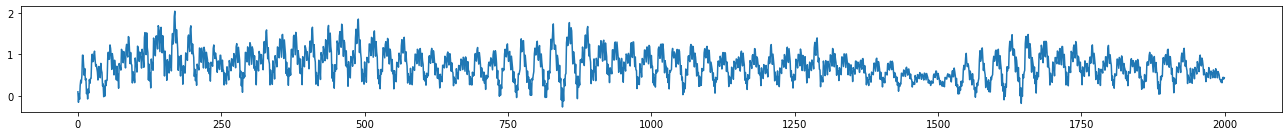

Epoch: 26 	 Discriminator Loss: [0.6354855, 0.768] 		 Generator Loss: 35.36796951293945
Epoch: 27 	 Discriminator Loss: [0.028242042, 0.996] 		 Generator Loss: 5.856156349182129
Epoch: 28 	 Discriminator Loss: [0.009696846, 0.998] 		 Generator Loss: 6.768627166748047
Epoch: 29 	 Discriminator Loss: [0.031729747, 0.992] 		 Generator Loss: 5.907753944396973
Epoch: 30 	 Discriminator Loss: [0.08087422, 0.97] 		 Generator Loss: 1.6466137170791626


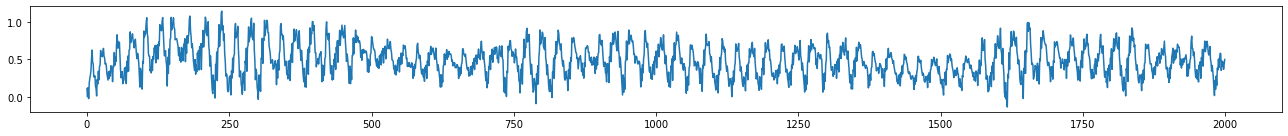

Epoch: 31 	 Discriminator Loss: [0.001289915, 1.0] 		 Generator Loss: 9.057449340820312
Epoch: 32 	 Discriminator Loss: [0.045373447, 0.984] 		 Generator Loss: 5.389925003051758
Epoch: 33 	 Discriminator Loss: [0.0012810433, 1.0] 		 Generator Loss: 17.397157669067383
Epoch: 34 	 Discriminator Loss: [1.3360027e-07, 1.0] 		 Generator Loss: 18.100976943969727
Epoch: 35 	 Discriminator Loss: [8.071534e-10, 1.0] 		 Generator Loss: 22.099475860595703


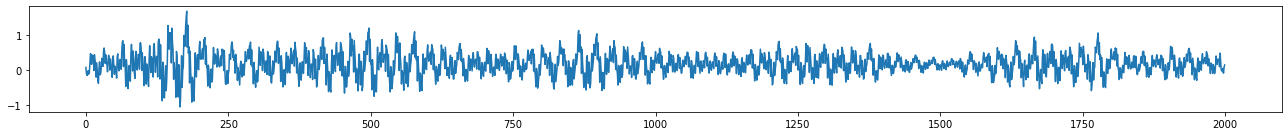

Epoch: 36 	 Discriminator Loss: [4.6503637e-10, 1.0] 		 Generator Loss: 22.48143196105957
Epoch: 37 	 Discriminator Loss: [1.1754561e-10, 1.0] 		 Generator Loss: 23.27326011657715
Epoch: 38 	 Discriminator Loss: [6.159843e-11, 1.0] 		 Generator Loss: 23.836774826049805
Epoch: 39 	 Discriminator Loss: [2.1043237e-10, 1.0] 		 Generator Loss: 22.84576988220215
Epoch: 40 	 Discriminator Loss: [5.235696e-11, 1.0] 		 Generator Loss: 31.45195198059082


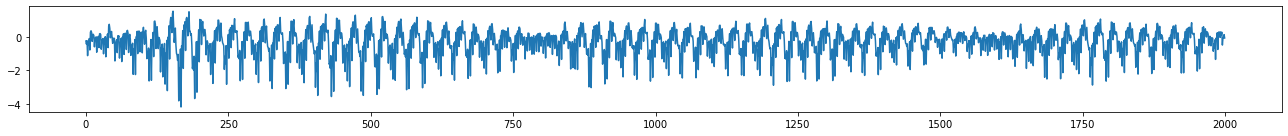

Epoch: 41 	 Discriminator Loss: [2.1252707e-13, 1.0] 		 Generator Loss: 40.345375061035156
Epoch: 42 	 Discriminator Loss: [9.217527e-21, 1.0] 		 Generator Loss: 61.09669494628906
Epoch: 43 	 Discriminator Loss: [6.369113, 0.506] 		 Generator Loss: 0.5324777960777283
Epoch: 44 	 Discriminator Loss: [10.697372, 0.502] 		 Generator Loss: 22.988636016845703
Epoch: 45 	 Discriminator Loss: [0.00047732203, 1.0] 		 Generator Loss: 20.27960968017578


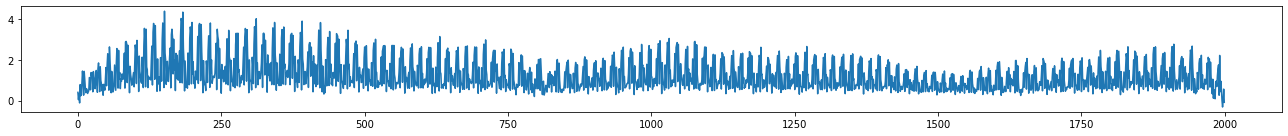

Epoch: 46 	 Discriminator Loss: [0.70660985, 0.802] 		 Generator Loss: 28.503253936767578
Epoch: 47 	 Discriminator Loss: [0.64956987, 0.818] 		 Generator Loss: 26.898366928100586
Epoch: 48 	 Discriminator Loss: [0.0012453281, 1.0] 		 Generator Loss: 18.26209831237793
Epoch: 49 	 Discriminator Loss: [0.03128006, 0.99] 		 Generator Loss: 10.148533821105957


In [13]:
disc_losses = []
disc_accuracies = []
gen_losses = []
def train_disc(epochs, batch_size, gen, disc):
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_trajs = db_train[np.arange(batch*batch_size, (batch+1)*batch_size)]
            fake_trajs = gen.predict(noise)
            trajs = np.concatenate((real_trajs, fake_trajs))
            
            disc_labels = np.zeros(2*batch_size)
            disc_labels[:batch_size] = 0.9
            disc_loss = disc.train_on_batch(trajs, disc_labels) # training del discriminatore (gli dico quali sono vere e quali no)            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_loss}')

def train_gan(epochs, batch_size, gen, disc, gan):
    static_noise = np.random.normal(0, 1, size=(1, noise_dim))
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_trajs = db_train[np.arange(batch*batch_size, (batch+1)*batch_size)]
            fake_trajs = gen.predict(noise)
            trajs = np.concatenate((real_trajs, fake_trajs))
            
            disc_labels = np.zeros(2*batch_size)
            disc_labels[:batch_size] = 1.0
            disc_loss = disc.train_on_batch(trajs, disc_labels) # training del discriminatore (gli dico quali sono vere e quali no)
    
            gen_labels = np.ones(batch_size)
            gen_loss = gan.train_on_batch(noise, gen_labels) # training del generatore (per imbrogliare il discrim.)
            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_loss} \t\t Generator Loss: {gen_loss}')
        disc_losses.append(disc_loss[0])
        disc_accuracies.append(disc_loss[1])
        gen_losses.append(gen_loss)
        if epoch%5==0:  plot_trajs(static_noise)
            
def train_gen(epochs, batch_size, gen, disc, gan):
    static_noise = np.random.normal(0, 1, size=(1, noise_dim))
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            gen_labels = np.ones(batch_size)
            gen_loss = gan.train_on_batch(noise, gen_labels) # training del generatore (per imbrogliare il discrim.)
            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Disc Loss: {disc_loss} \t Gen Loss: {gen_loss}')
        disc_losses.append(disc_loss[0])
        disc_accuracies.append(disc_loss[1])
        gen_losses.append(gen_loss)
        if epoch%5==0:  plot_trajs(static_noise)

batch_size = 250
train_gan(epochs=50, batch_size=batch_size, gen=gen, disc=disc, gan=gan)
#train_disc(epochs=3, batch_size=batch_size, gen=gen, disc=disc)

In [1]:
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(disc_losses, label='discriminator loss')
ax1.plot(gen_losses, label='generator loss')
ax2.plot(disc_accuracies, label='discriminator accuracy')
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

NameError: name 'disc_losses' is not defined

# Testing

In [ ]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
disc.evaluate(gen.predict(noise),np.zeros(batch_size))
disc.evaluate(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)],np.ones(batch_size))

In [ ]:
disc.predict(gen.predict(noise))
#disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)])

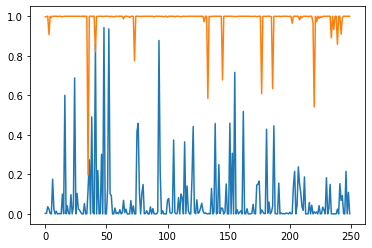

In [154]:
plt.plot(disc.predict(gen.predict(noise)))
plt.plot(disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)]))

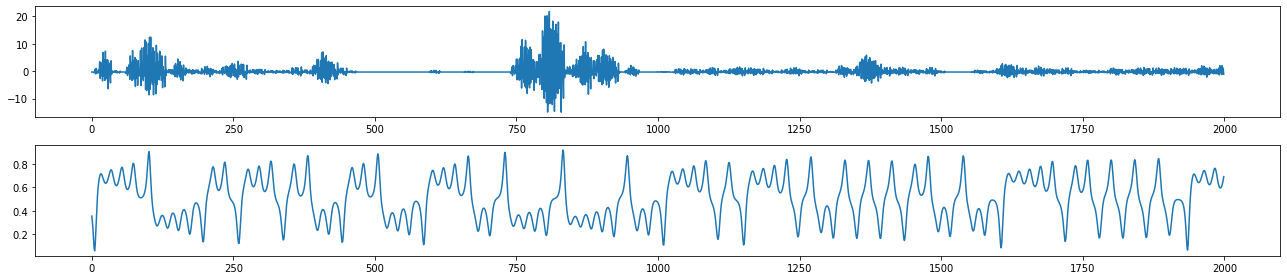

In [9]:
static_noise = np.random.normal(0, 1, size=(1, noise_dim))
plot_trajs(static_noise, db_train)

# Saving

In [60]:
disc.save('gan_disc.h5')
gen.save('gan_gen.h5')
#from tensorflow.keras.models import load_model
#disc = load_model('classificatore.h5')